In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version
# Check python
!which python

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

/mnt/nvme0n1/miniconda3/envs/hieu/bin/python


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
# # install dependencies: (use cu111 because colab has CUDA 11.1)
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# # install mmcv-full thus we could use CUDA operators
# !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# # Install mmdetection
# !pip install mmdet

# !pip install mmrotate

In [3]:
from mmcv import collect_env
collect_env()

/mnt/nvme0n1/miniconda3/envs/hieu/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'sys.platform': 'linux',
 'Python': '3.7.11 (default, Jul 27 2021, 14:32:16) [GCC 7.5.0]',
 'CUDA available': True,
 'GPU 0': 'NVIDIA GeForce RTX 3060 Ti',
 'GPU 1': 'NVIDIA GeForce GTX 1650',
 'CUDA_HOME': '/usr/local/cuda-11.1',
 'NVCC': 'Build cuda_11.1.TC455_06.29190527_0',
 'GCC': 'gcc (Ubuntu 9.4.0-1ubuntu1~20.04) 9.4.0',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code

In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMRotate installation
import mmrotate
print(mmrotate.__version__)

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
0.1.1
2.22.0
11.1
GCC 7.3


In [5]:
import mmcv
import matplotlib.pyplot as plt

In [6]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
# !wget -c https://download.openmmlab.com/mmrotate/v0.1.0/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth \
#       -O checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth

In [41]:
!wget -c https://download.openmmlab.com/mmrotate/v0.1.0/rotated_retinanet/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth \
      -O checkpoints/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth

--2022-03-17 12:47:56--  https://download.openmmlab.com/mmrotate/v0.1.0/rotated_retinanet/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.18
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146852804 (140M) [application/octet-stream]
Saving to: ‘checkpoints/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth’

checkpoints/rotated 100%[===================>] 140,05M  9,81MB/s    in 14s     

2022-03-17 12:48:11 (9,88 MB/s) - ‘checkpoints/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth’ saved [146852804/146852804]



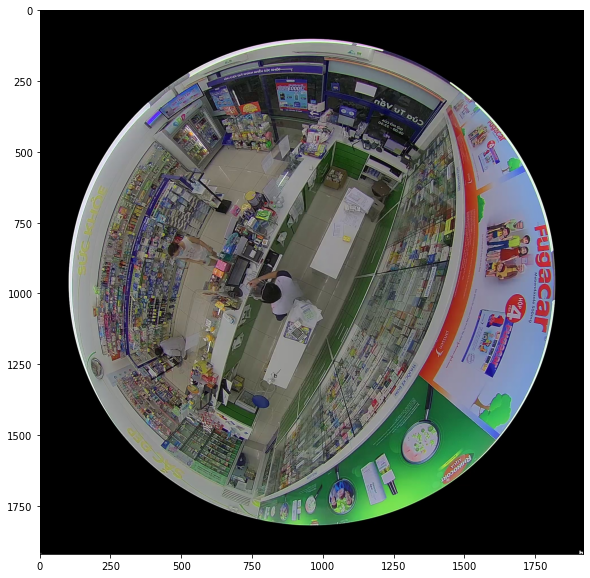

In [7]:
# Let's take a look at the dataset image
img = mmcv.imread('../../../data/PhamacityDota/images/linhdam2_10.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [8]:
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset


@ROTATED_DATASETS.register_module()
class PharmacityDataset(DOTADataset):
    CLASSES = ('person',)

In [34]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

In [42]:
from mmcv import Config
cfg = Config.fromfile('../configs/rotated_retinanet/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90.py')

In [43]:
!pwd

/mnt/nvme0n1/hieudao/git/mmrotate/demo


In [44]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'PharmacityDataset'
cfg.data_root = '../../../data/PhamacityDota'

cfg.data.test.type = 'PharmacityDataset'
cfg.data.test.data_root = '../../../data/PhamacityDota'
cfg.data.test.ann_file = 'dota'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'PharmacityDataset'
cfg.data.train.data_root = '../../../data/PhamacityDota'
cfg.data.train.ann_file = 'dota'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'PharmacityDataset'
cfg.data.val.data_root = '../../../data/PhamacityDota'
cfg.data.val.ann_file = 'dota'
cfg.data.val.img_prefix = 'images'

# modify num classes of the model in box head
# cfg.model.roi_head.bbox_head.num_classes = 1
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth'
# cfg.load_from = './tutorial_exps/epoch_3.pth.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.001
cfg.lr_config.warmup = None
cfg.runner.max_epochs = 3
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 3

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

# We can initialize the logger for training and have a look
# at the final config used for training
# print(f'Config:\n{cfg.pretty_text}')

In [ ]:
import os.path as osp

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-03-17 12:48:44,333 - mmdet - INFO - load checkpoint from local path: checkpoints/rotated_retinanet_obb_r50_fpn_1x_dota_ms_rr_le90-1da1ec9c.pth
2022-03-17 12:48:44,651 - mmdet - INFO - Start running, host: hieudao@mdt-System-Product-Name, work_dir: /mnt/nvme0n1/hieudao/git/mmrotate/demo/tutorial_exps
2022-03-17 12:48:44,652 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
 -------------------- 
before_train_iter:

In [ ]:
# # load tensorboard in colab
# %load_ext tensorboard

# # see curves in tensorboard
# %tensorboard --logdir ./tutorial_exps

In [40]:
img = mmcv.imread('../../../data/Phamacity/images/linhdam2_10.jpg')
model.cfg = cfg

torch.cuda.synchronize()
start_time = time.perf_counter()

result = inference_detector(model, img)

torch.cuda.synchronize()
elapsed = time.perf_counter() - start_time

model.show_result(img, result, score_thr=0.3, out_file='./det_linhdam2_10.jpeg')
img = mmcv.imread('./det_linhdam2_10.jpeg')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/Phamacity/images/linhdam2_10.jpg'

In [28]:
!python ../tools/analysis_tools/benchmark.py \
  ../configs/rotated_retinanet/rotated_retinanet_obb_r50_fpn_1x_dota_le90.py \
  tutorial_exps/epoch_3.pth 
        

Traceback (most recent call last):
  File "../tools/analysis_tools/benchmark.py", line 219, in <module>
    main()
  File "../tools/analysis_tools/benchmark.py", line 209, in main
    raise NotImplementedError('Only supports distributed mode')
NotImplementedError: Only supports distributed mode


In [15]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = '../configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py'
# Setup a checkpoint file to load
checkpoint = 'tutorial_exps/epoch_3.pth'

# Set the device to be used for evaluation
device='cuda:1'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: tutorial_exps/epoch_3.pth
The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([2, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([16]).


OrientedRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
# Let's plot the result
import mmcv
import matplotlib.pyplot as plt

# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

model.show_result(img, result, score_thr=0.3, out_file='./det.jpeg')
img = mmcv.imread('./det.jpeg')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [13]:
import time

In [ ]:
img = mmcv.imread('../../../data/Phamacity/images/linhdam2_10.jpg')

torch.cuda.synchronize()
start_time = time.perf_counter()

result = inference_detector(model, img)

torch.cuda.synchronize()
elapsed = time.perf_counter() - start_time

model.show_result(img, result, score_thr=0.3, out_file='./det_linhdam2_10.jpeg')
img = mmcv.imread('./det_linhdam2_10.jpeg')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()